<a href="https://colab.research.google.com/github/mvergaral/UniversityConnect/blob/master/UnivesityConnect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
!pip install osmnx
!pip install folium

In [86]:
import geopandas as gpd
import pandas as pd
import folium
import requests
import osmnx as ox
import networkx as nx
from folium.plugins import HeatMap
from shapely.geometry import Polygon, Point
from concurrent.futures import ThreadPoolExecutor
from itertools import chain


df = pd.read_csv('PUCV20222023.csv')

# Capitalizamos para evitar inconsistencia en la busqueda
df['nom_com_rbd'] = df['nom_com_rbd'].str.capitalize()

print(df['nom_com_rbd'].value_counts())


nom_com_rbd
Viña del mar     1723
Valparaíso       1311
Quilpué           943
Villa alemana     846
Quillota          674
                 ... 
Pirque              1
Hualaihué           1
Conchalí            1
Maule               1
San joaquín         1
Name: count, Length: 210, dtype: int64


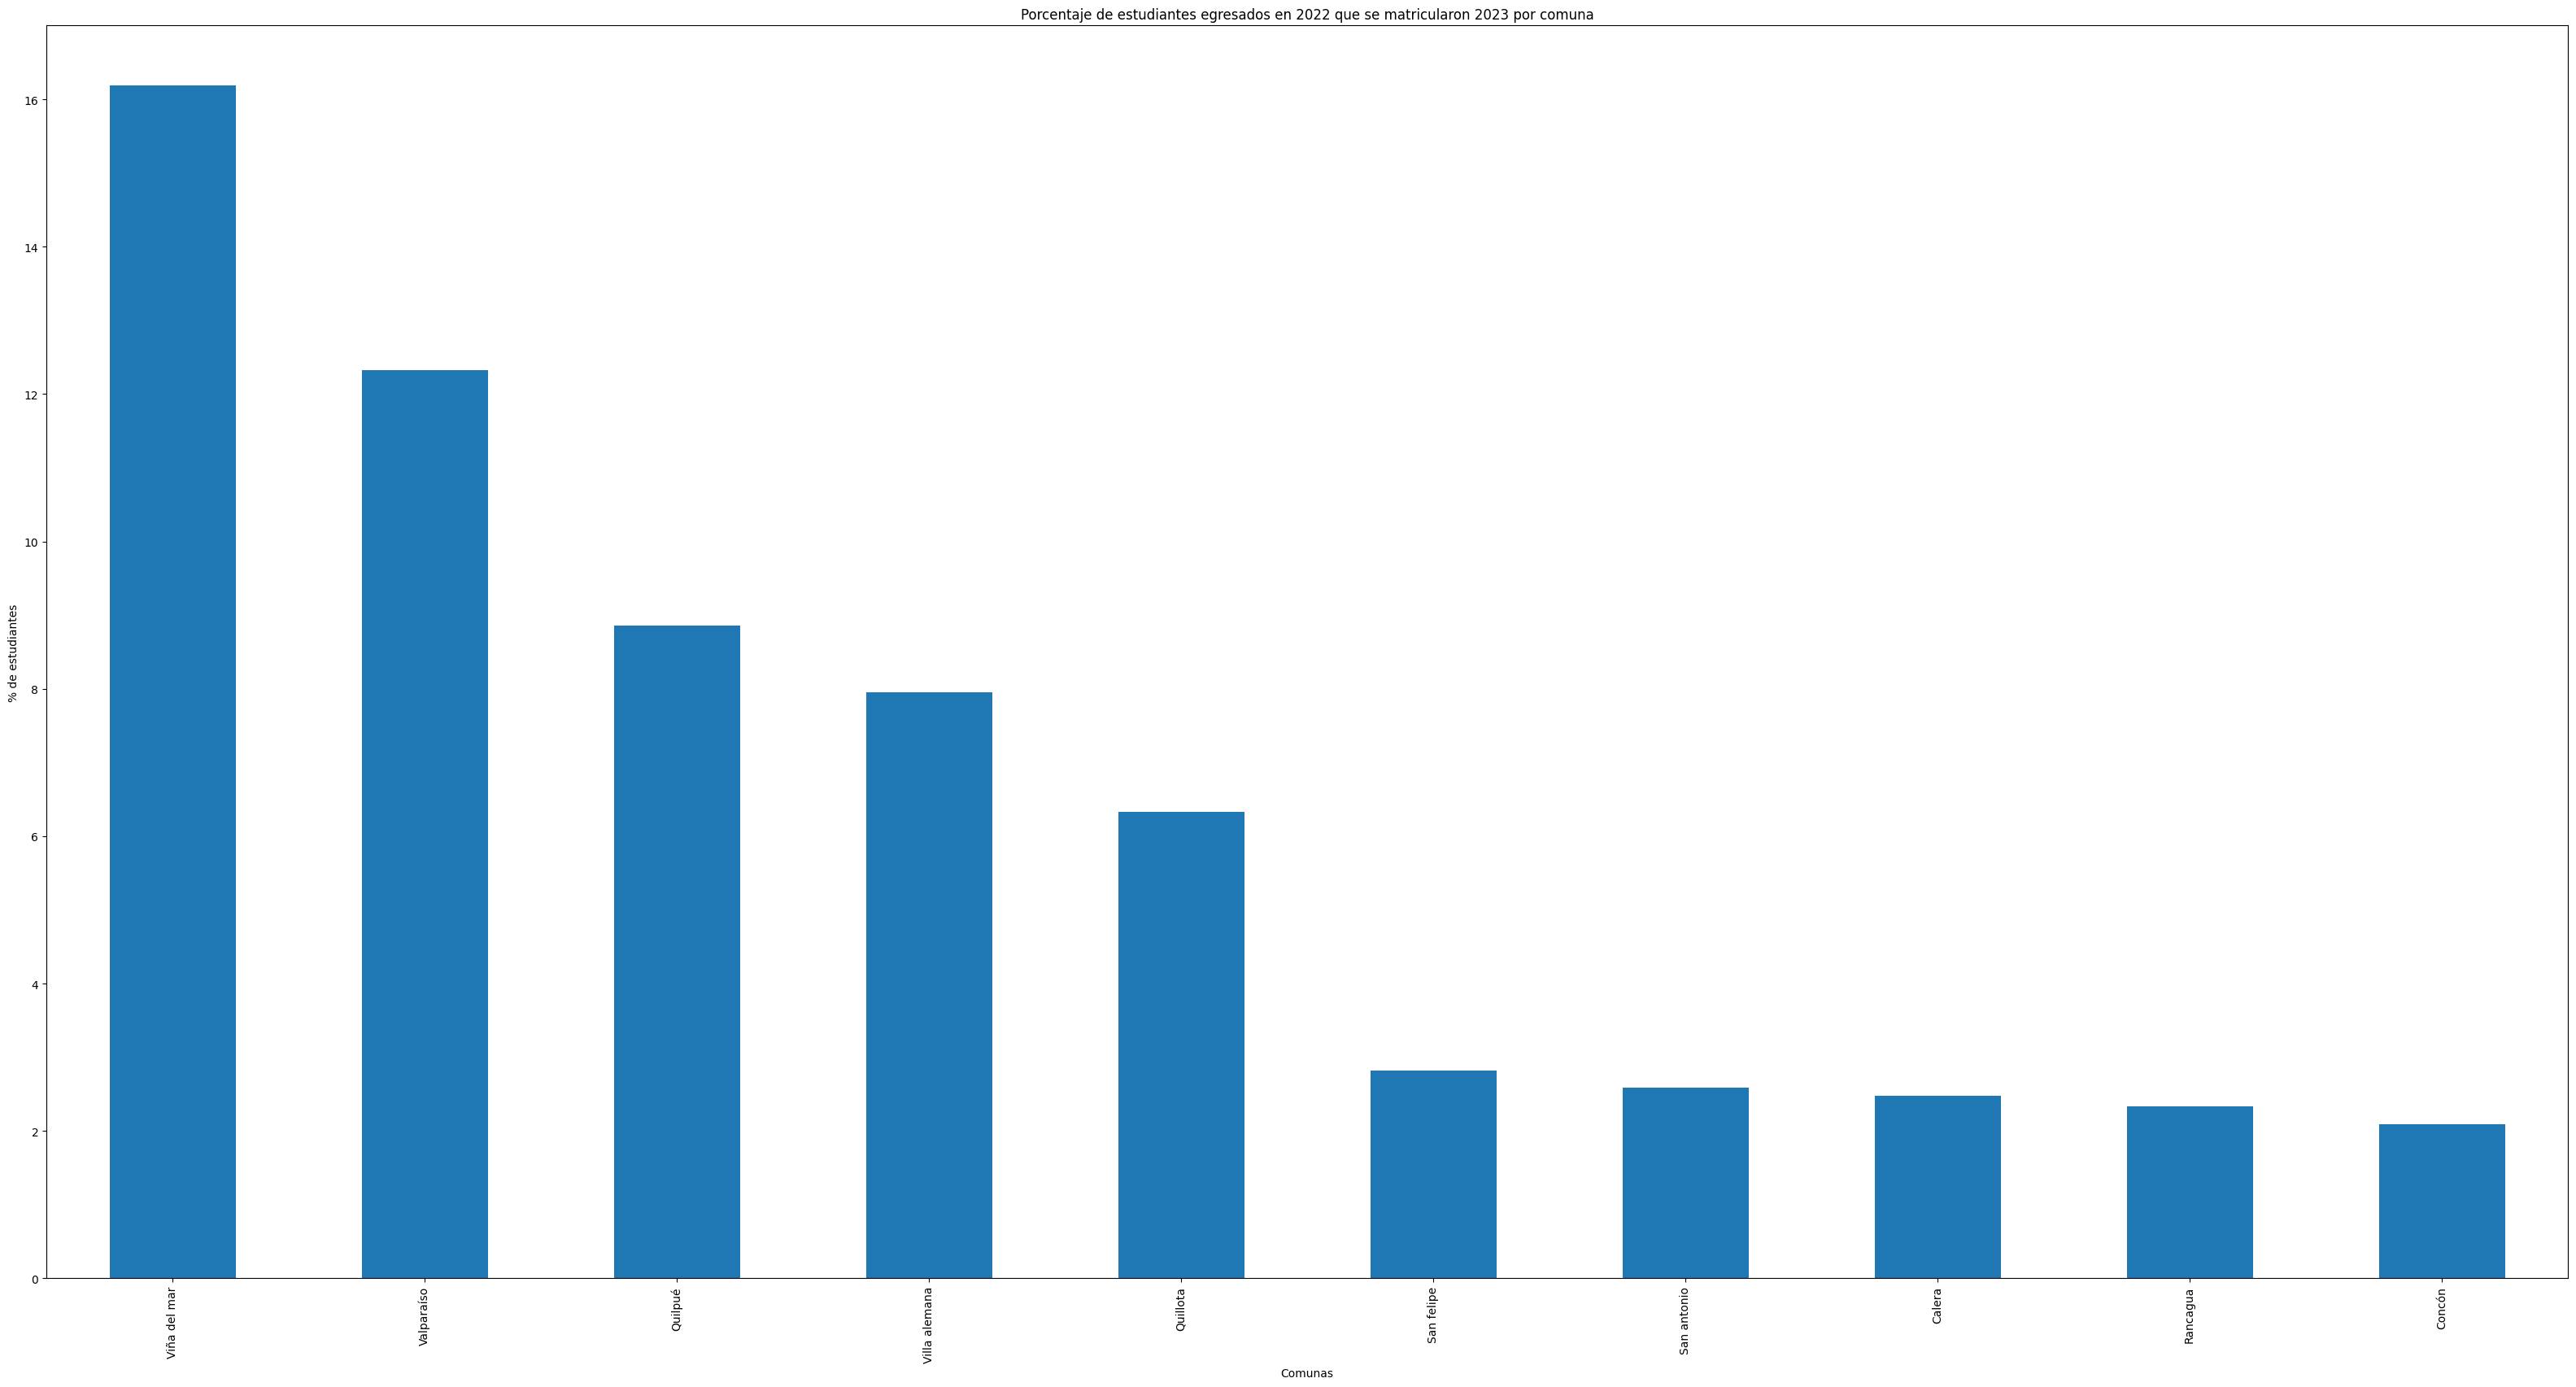

In [95]:
import matplotlib.pyplot as plt

count_by_nom_com_rbd = df['nom_com_rbd'].value_counts().head(10)
percentage_by_nom_com_rbd = (count_by_nom_com_rbd / len(df)) * 100

plt.figure(figsize=(40, 20))
percentage_by_nom_com_rbd.plot(kind='bar')

plt.xlabel('Comunas')
plt.ylabel('% de estudiantes')
plt.title('Porcentaje de estudiantes egresados en 2022 que se matricularon 2023 por comuna')

plt.xticks(rotation=90)

plt.show()


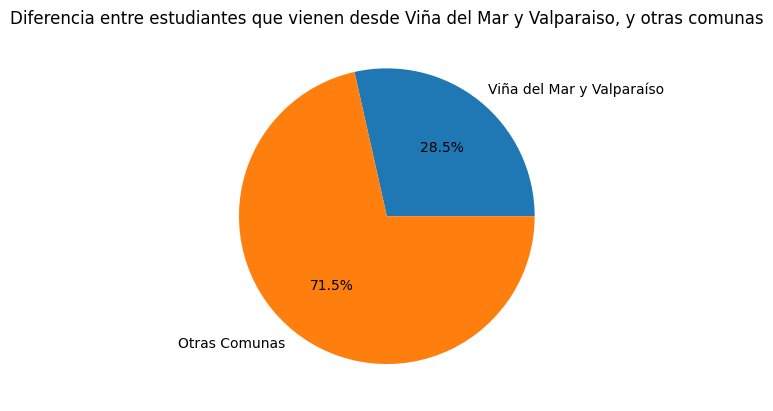

In [39]:
import matplotlib.pyplot as plt

vina_valpo = df[df['nom_com_rbd'].isin(['Viña del mar', 'Valparaíso'])]
other = df[~df['nom_com_rbd'].isin(['Viña del mar', 'Valparaíso'])]

vina_valpo_count = len(vina_valpo)
other_count = len(other)

labels = ['Viña del Mar y Valparaíso', 'Otras Comunas']

values = [vina_valpo_count, other_count]

plt.pie(values, labels=labels, autopct="%1.1f%%")

plt.title('Diferencia entre estudiantes que vienen desde Viña del Mar y Valparaiso, y otras comunas')

plt.show()


In [43]:
count_by_nom_com_rbd.head(10)


nom_com_rbd
Viña del mar     1723
Valparaíso       1311
Quilpué           943
Villa alemana     846
Quillota          674
San felipe        300
San antonio       275
Calera            264
Rancagua          248
Concón            223
Name: count, dtype: int64

In [47]:
# Primero, obtendremos la serie con las 10 comunas con más datos
top_comunas = df['nom_com_rbd'].value_counts().head(10).index

# Filtrar el DataFrame original para obtener solo las filas correspondientes a las 10 comunas principales
df_top_comunas = df[df['nom_com_rbd'].isin(top_comunas)]

# Mostrar las 10 comunas con más datos
print(df_top_comunas['nom_com_rbd'].value_counts())

nom_com_rbd
Viña del mar     1723
Valparaíso       1311
Quilpué           943
Villa alemana     846
Quillota          674
San felipe        300
San antonio       275
Calera            264
Rancagua          248
Concón            223
Name: count, dtype: int64


In [52]:
# Reemplazamos el valor Calera por La calera para mantener consistencia
top_comunas = top_comunas.str.replace('Calera', 'La calera')
print(top_comunas)


Index(['Viña del mar', 'Valparaíso', 'Quilpué', 'Villa alemana', 'Quillota',
       'San felipe', 'San antonio', 'La calera', 'Rancagua', 'Concón'],
      dtype='object', name='nom_com_rbd')


In [53]:
# Función para obtener datos de comunas de Chile desde OSM usando la API de Overpass
def obtener_comunas_chile():
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
    [out:json];
    area["ISO3166-1"="CL"][admin_level=2];
    (
      relation["admin_level"="8"](area);
    );
    out body;
    >;
    out skel qt;
    """
    response = requests.get(overpass_url, params={'data': overpass_query})
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print("Error al obtener los datos de Overpass API")
        return None

# Función para obtener coordenadas de 'ways' referenciados
def obtener_coords_way(way_ids):
    overpass_url = "http://overpass-api.de/api/interpreter"
    way_coords = {}
    chunk_size = 50  # Tamaño de los bloques para dividir las consultas
    for i in range(0, len(way_ids), chunk_size):
        chunk = way_ids[i:i + chunk_size]
        way_ids_str = ','.join(map(str, chunk))
        overpass_query = f"""
        [out:json];
        way(id:{way_ids_str});
        out geom;
        """
        response = requests.get(overpass_url, params={'data': overpass_query})
        if response.status_code == 200:
            way_data = response.json()
            for element in way_data.get('elements', []):
                if 'geometry' in element:
                    way_coords[element['id']] = [(point['lon'], point['lat']) for point in element['geometry']]
        else:
            print(f"Error al obtener datos de Overpass API para ways {way_ids_str}")
    return way_coords

# Obtener los datos de comunas
comunas_data = obtener_comunas_chile()
if comunas_data is None:
    raise ValueError("No se pudieron obtener los datos de comunas")

# Filtrar solo las comunas seleccionadas
comunas_filtered = [element for element in comunas_data['elements'] if 'tags' in element and element['tags'].get('name').capitalize() in top_comunas]

# Recopilar todas las referencias de 'way' y sus IDs
way_ids = set()
comunas_names = []
comunas_way_refs = []

for element in comunas_filtered:
    if 'tags' in element and 'name' in element['tags']:
        comunas_names.append(element['tags']['name'].capitalize())
        refs = [member['ref'] for member in element['members'] if member['type'] == 'way']
        comunas_way_refs.append(refs)
        way_ids.update(refs)

# Obtener todas las geometrías de 'ways' en una sola consulta
way_coords = obtener_coords_way(list(way_ids))

# Construir las geometrías de las comunas
comunas_geometries = []
for refs in comunas_way_refs:
    coords = []
    for ref in refs:
        if ref in way_coords:
            coords.extend(way_coords[ref])
    if coords:
        comunas_geometries.append(Polygon(coords))
    else:
        comunas_geometries.append(None)

# Crear un GeoDataFrame a partir de los datos obtenidos
comunas = gpd.GeoDataFrame({'Comuna': comunas_names, 'geometry': comunas_geometries})

# Calcular los centroides de las comunas
comunas['centroid'] = comunas['geometry'].centroid

# Extraer las coordenadas de los centroides
comunas['Latitude'] = comunas['centroid'].apply(lambda x: x.y)
comunas['Longitude'] = comunas['centroid'].apply(lambda x: x.x)

In [67]:
# Función para obtener los POI de una comuna desde la API de Overpass
def obtener_poi_comuna(comuna_name):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"""
    [out:json];
    area["name"="{comuna_name}"]["admin_level"="8"];
    node(area)["place"~"town|village|hamlet|suburb|neighbourhood"];
    out center;
    """
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()
    return data

# Crear un DataFrame con las coordenadas de los POI de cada comuna
poi_coords = []
for idx, row in comunas.iterrows():
    poi_data = obtener_poi_comuna(row['Comuna'])
    if 'elements' in poi_data and len(poi_data['elements']) > 0:
        poi = poi_data['elements'][0]  # Usar el primer POI encontrado
        poi_coords.append({
            'Comuna': row['Comuna'],
            'Latitude': poi['lat'],
            'Longitude': poi['lon']
        })
    else:
        # Si no se encuentran POI, usar el centroide de la geometría como fallback
        poi_coords.append({
            'Comuna': row['Comuna'],
            'Latitude': row['Latitude'],
            'Longitude': row['Longitude']
        })

df_poi_coords = pd.DataFrame(poi_coords)

# Verificar el DataFrame de POI
print(df_poi_coords)

          Comuna   Latitude  Longitude
0         Concón -32.922004 -71.515957
1   Viña del mar -33.021269 -71.528829
2        Quilpué -33.053777 -71.423891
3     Valparaíso -33.028449 -71.637866
4  Villa alemana -33.247507 -71.684115
5       Quillota -32.920570 -71.443269
6      La calera -32.802625 -71.167356
7     San felipe -32.761279 -70.689600
8    San antonio -33.607136 -71.500459
9       Rancagua -34.029963 -60.504583


In [68]:
print(comunas)

          Comuna                                           geometry  \
0         Concón  POLYGON ((-71.54549 -32.94680, -71.53997 -32.9...   
1   Viña del mar  POLYGON ((-71.49376 -33.10270, -71.49393 -33.0...   
2        Quilpué  POLYGON ((-70.99725 -33.19883, -71.00225 -33.1...   
3     Valparaíso  POLYGON ((-71.49376 -33.10270, -71.49633 -33.1...   
4  Villa alemana  POLYGON ((-71.40057 -33.01323, -71.39943 -33.0...   
5       Quillota  POLYGON ((-71.44288 -32.92332, -71.44374 -32.9...   
6      La calera  POLYGON ((-71.15682 -32.86428, -71.15699 -32.8...   
7     San felipe  POLYGON ((-70.75231 -32.80761, -70.75592 -32.8...   
8    San antonio  POLYGON ((-71.62692 -33.57881, -71.62692 -33.5...   
9       Rancagua  POLYGON ((-70.84222 -34.19228, -70.84279 -34.1...   

                      centroid   Latitude  Longitude  
0  POINT (-71.46134 -32.95395) -32.953948 -71.461345  
1  POINT (-71.52883 -33.02127) -33.021269 -71.528829  
2  POINT (-71.22557 -33.13229) -33.132290 -71.225569 

In [94]:
# Definir el punto de destino en Valparaíso
destino = Point(-71.6056, -33.0447)  # Coordenadas del punto de destino en Valparaíso

# Crear un mapa base centrado en Valparaíso
m = folium.Map(location=[-33.0447, -71.6056], zoom_start=12)

# Añadir un marcador para el punto de destino
folium.Marker([destino.y, destino.x], popup='Destino en Valparaíso', icon=folium.Icon(color='red')).add_to(m)

# Crear rutas desde el POI de cada comuna al destino en Valparaíso
for idx, row in df_poi_coords.iterrows():
    origen = (row['Latitude'], row['Longitude'])
    try:
        # Obtener el grafo de calles alrededor del punto de origen
        G = ox.graph_from_point(origen, dist=40000, network_type="drive")

        # Filtrar para incluir solo autopistas y carreteras principales
        edges = ox.graph_to_gdfs(G, nodes=False)
        highway_classes = ['secondary_link', 'primary', 'trunk_link', 'motorway_link', 'tertiary_link', 'motorway', 'tertiary', 'trunk', 'primary_link', 'residential', 'secondary', 'unclassified']
        edges = edges[edges['highway'].apply(lambda x: any(item in x for item in highway_classes))]
        nodes = ox.graph_to_gdfs(G, edges=False, node_geometry=True)
        G = ox.graph_from_gdfs(nodes, edges)

        # Asegurarse de que el grafo esté conectado
        G = ox.truncate.largest_component(G)
        # Encontrar los nodos más cercanos al origen y destino
        origen_node = ox.distance.nearest_nodes(G, X=row['Longitude'], Y=row['Latitude'])
        destino_node = ox.distance.nearest_nodes(G, X=destino.x, Y=destino.y)

        # Calcular la ruta más corta
        ruta = nx.shortest_path(G, origen_node, destino_node, weight='length')

        # Obtener las coordenadas de la ruta
        ruta_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in ruta]

        # Añadir la ruta al mapa
        folium.PolyLine(ruta_coords, color='blue', weight=2.5, opacity=1).add_to(m)
    except Exception as e:
        print(f"No se pudo calcular la ruta para la comuna {row['Comuna']}: {e}")

# Añadir zonas de calor alrededor del centro de cada comuna
heat_data = [[row['Latitude'], row['Longitude']] for idx, row in df_poi_coords.iterrows()]
HeatMap(heat_data).add_to(m)

# Mostrar el mapa en Jupyter Notebook/Google Colab
from IPython.display import display
display(m)

No se pudo calcular la ruta para la comuna Villa alemana: No path between 9395187211 and 262528952.


In [91]:
# Elegir un punto y un área de ejemplo
lugar_ejemplo = (-33.0447, -71.6056)  # Coordenadas de Nueva York, por ejemplo

# Descargar el grafo de calles para el área de ejemplo
G = ox.graph_from_point(lugar_ejemplo, dist=10000, network_type='drive')

# Convertir el grafo a un GeoDataFrame de aristas
edges = ox.graph_to_gdfs(G, nodes=False)

# Aplanar las listas en la columna 'highway' y obtener los tipos únicos
highway_classes = set(chain.from_iterable(edges['highway'].apply(lambda x: x if isinstance(x, list) else [x])))

# Mostrar los tipos únicos de 'highway'
print("Tipos únicos de 'highway':")
print(highway_classes)

Tipos únicos de 'highway':
{'secondary_link', 'primary', 'trunk_link', 'motorway_link', 'tertiary_link', 'motorway', 'living_street', 'tertiary', 'trunk', 'primary_link', 'escape', 'residential', 'secondary', 'unclassified'}
